## Import packages

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

## Load evaluation score

In [2]:
def load_json(file_path):
    if not os.path.exists(file_path):
        return None
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [3]:
input_dir = '../../data/eval_important_evo'
fig_dir = '../../data/fig/eval'
models = ['vgg16-512-0.01-0.9']
model = models[0]

### Vgg16, freezing

In [4]:
def make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos, traintest):
    
    # Get ready
    data_dir = os.path.join(input_dir, model, 'data')
    model_data = {
        'from': {},
        'to': {},
        eval_type: {}
    }
    from_to = from_tos[model]
    
    for ratio in eval_sample_ratios:
        
        # eval_important_evo-test-option=freezing-label=943-find_num_sample_imgs=50-eval_sample_ratio=0.5-from=vgg16_512_0.01_0.9_5-to=vgg16_512_0.01_0.9_21
        # File path
        settings = [
            ['eval_important_evo-option', eval_type],
            ['label', label],
            ['find_num_sample_imgs', 50],
            ['eval_sample_ratio', ratio],
            ['from', from_to[0]],
            ['to', from_to[1]]
        ]
        file_path = os.path.join(
            data_dir, 
            '-'.join(['{}={}'.format(s[0], s[1]) for s in settings]) + '.json'
        )
        file_path = file_path.replace('eval_important_evo-', 'eval_important_evo-' + traintest + '-')
        data = load_json(file_path)
        if data is None:
            print('here')
            continue

        # Initialize data
        agg_data = {
            'from': data['from'],
            'to': data['to'],
            'important': {
                'top1': {'correct': 0, 'incorrect': 0},
                'topk': {'correct': 0, 'incorrect': 0},
            },
            'least-important': {
                'top1': {'correct': 0, 'incorrect': 0},
                'topk': {'correct': 0, 'incorrect': 0},
            },
            'random': {
                'top1': {'correct': 0, 'incorrect': 0},
                'topk': {'correct': 0, 'incorrect': 0},
            }
        }

        # Aggregate data of all layers
        layers = list(data['important'].keys())
        for key in ['important', 'least-important', 'random']:
            for layer in layers:
                for inner_key in ['top1', 'topk']:
                    for val_type in ['correct', 'incorrect']:
                        agg_data[key][inner_key][val_type] += data[key][layer][inner_key][val_type]

        # Compute score
        for key in agg_data:
            for inner_key in ['top1', 'topk']:
                corrects = agg_data[key][inner_key]['correct']
                incorrects = agg_data[key][inner_key]['incorrect']
                score = corrects / (corrects + incorrects)
                agg_data[key][inner_key]['acc'] = score

        # Save score
        model_data['from'] = data['from']
        model_data['to'] = data['to']
        model_data[eval_type][ratio] = {}
        for key in ['important', 'least-important', 'random']:
            model_data[eval_type][ratio][key] = agg_data[key]

    return model_data
                
    
def draw_graph(label, model_data, eval_type='freezing', eps=0.5):
    # Draw plots
    for key in ['top1', 'topk']:
        for model in models:

            # Draw baseline
            ratios = list(model_data[eval_type].keys())
            for inner_key in ['from', 'to']:
            # for inner_key in ['to']:
                vals = [model_data[inner_key][key]['acc']] * len(ratios)
                plt.plot(ratios, vals, 'o--', label=inner_key)

            # Draw values by sample ratio
            for inner_key in ['important', 'least-important', 'random']:
                vals = [model_data[eval_type][ratio][inner_key][key]['acc'] for ratio in ratios]
                plt.plot(ratios, vals, 'o--', label=inner_key)

            # Legend
            title = 'label={}, {}'.format(label, key)
            if eval_type == 'perturbation':
                title += ', eps={}'.format(eps)
            plt.title(title)
            plt.legend()
            plt.show()


In [27]:
def draw_avg_graph(labels, input_dir, model, eval_type, eval_sample_ratios, from_tos, path, traintest='train'):
    avg_data = {
        'from': {
            'top1': {'correct': 0, 'incorrect': 0},
            'topk': {'correct': 0, 'incorrect': 0},
        },
        'to': {
            'top1': {'correct': 0, 'incorrect': 0},
            'topk': {'correct': 0, 'incorrect': 0},
        },
        eval_type: {}
    }
    
    for label in labels:
        model_data = make_data(input_dir, model, eval_type, label, eval_sample_ratios, from_tos, traintest)
        ratios = list(model_data[eval_type].keys())
        
        if len(avg_data[eval_type]) == 0:
            for ratio in ratios:
                avg_data[eval_type][ratio] = {}
                for key in ['important', 'least-important', 'random']:
                    avg_data[eval_type][ratio][key] = {
                        'top1': {'correct': 0, 'incorrect': 0},
                        'topk': {'correct': 0, 'incorrect': 0},
                    }
                    
        # Collect data from baseline
        for key in ['from', 'to']:
            for inner_key in ['top1', 'topk']:
                for val_type in ['correct', 'incorrect']:
                    avg_data[key][inner_key][val_type] += model_data[key][inner_key][val_type]
                    
        # Collect data
        for ratio in ratios:
            for key in ['important', 'least-important', 'random']:
                for inner_key in ['top1', 'topk']:
                    for val_type in ['correct', 'incorrect']:
                        avg_data[eval_type][ratio][key][inner_key][val_type] += model_data[eval_type][ratio][key][inner_key][val_type]
                        
        # Compute score of baselines
        for key in ['from', 'to']:
            for inner_key in ['top1', 'topk']:
                correct = avg_data[key][inner_key]['correct']
                incorrect = avg_data[key][inner_key]['incorrect']
                acc = correct / (correct + incorrect)
                avg_data[key][inner_key]['acc'] = acc
                
        # Compute score of data
        for ratio in ratios:
            for key in ['important', 'least-important', 'random']:
                for inner_key in ['top1', 'topk']:
                    correct = avg_data[eval_type][ratio][key][inner_key]['correct']
                    incorrect = avg_data[eval_type][ratio][key][inner_key]['incorrect']
                    acc = correct / (correct + incorrect)
                    avg_data[eval_type][ratio][key][inner_key]['acc'] = acc
                    
        
    # Draw graph
    for key in ['top1', 'topk']:

        # Draw baseline
        # for inner_key in ['from', 'to']:
        for inner_key in ['to']:
            vals = [avg_data[inner_key][key]['acc']] * len(ratios)
            plt.plot(ratios, vals, '^--', label=inner_key, markersize=15, linewidth=3)

        # Draw values by sample ratio
        shape = {
            'random': 's--', 
            'important': 'o-',
            'least-important': 'X--'
        }
        for inner_key in ['random', 'important', 'least-important']:
            vals = [avg_data[eval_type][ratio][inner_key][key]['acc'] for ratio in ratios]
            plt.plot(ratios, vals, shape[inner_key], label=inner_key, markersize=15, linewidth=3)

        # Legend
        # title = '{}, labels={}'.format(key, labels)
        # if eval_type == 'perturbation':
        #     title += ', eps={}'.format(eps)
        title = 'train, {}'.format(key)
        ylabel = ' '.join([key.replace('t', 'T'), traintest, 'accuracy'])
            
        # plt.ylabel(ylabel)
        # plt.xlabel('Rate of frozen concept evolutions per layer')
        # plt.title(title)
        # plt.legend()
        plt.savefig(path[key])
        
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=14)
        

        print(path[key])
        plt.show()

In [28]:
# find labels
train_labels = {
    '5->21': {},
    '21->207': {}
}
test_labels = {
    '5->21': {},
    '21->207': {}
}

for filename in os.listdir(os.path.join(input_dir, 'vgg16-512-0.01-0.9', 'data')):
    # print(filename)
    label = int(filename.split('label=')[1].split('-')[0])
    ratio = filename.split('eval_sample_ratio=')[1].split('-')[0]
    to = int(filename.split('_')[-1].split('.')[0])
    key = '5->21' if to == 21 else '21->207'

    if 'train' in filename:
        if label not in train_labels[key]:
            train_labels[key][label] = []
        train_labels[key][label].append(ratio)
    elif 'test' in filename:
        if label not in test_labels[key]:
            test_labels[key][label] = []
        test_labels[key][label].append(ratio)
        
# Final labels
final_train_labels = {
    '5->21': [],
    '21->207': []
}

final_test_labels = {
    '5->21': [],
    '21->207': []
}

for key in ['5->21', '21->207']:
    for label in train_labels[key]:
        if len(train_labels[key][label]) == 4:
            final_train_labels[key].append(label)
            
for key in ['5->21', '21->207']:
    for label in test_labels[key]:
        if len(test_labels[key][label]) == 4:
            final_test_labels[key].append(label)
        
print(len(final_test_labels['5->21']))
print(len(final_test_labels['21->207']))

100
100


In [29]:
eps = 0.5 # It is not used for freezing version

eval_type = 'freezing'
eval_sample_ratios = [0.1, 0.3, 0.5, 0.7]
from_tos = {
    'inception_v3-512-0.5-0.9': ['inception_v3_512_0.5_0.9_11', 'inception_v3_512_0.5_0.9_121'],
    'vgg16-512-0.01-0.9': ['vgg16_512_0.01_0.9_5', 'vgg16_512_0.01_0.9_21']
}

../../data/fig/eval/5-21-top1-train.pdf


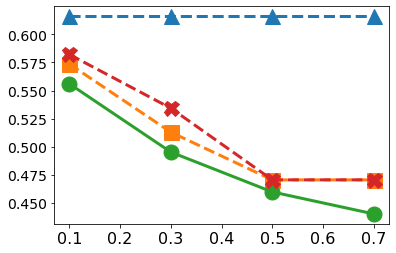

../../data/fig/eval/5-21-topk-train.pdf


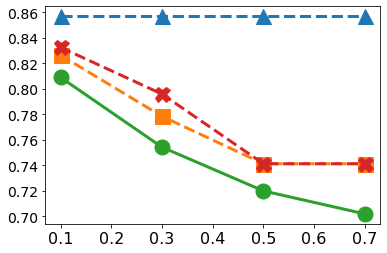

In [30]:
traintest = 'train'
labels = train_labels['5->21']
from_tos = {
    'inception_v3-512-0.5-0.9': ['inception_v3_512_0.5_0.9_11', 'inception_v3_512_0.5_0.9_121'],
    'vgg16-512-0.01-0.9': ['vgg16_512_0.01_0.9_5', 'vgg16_512_0.01_0.9_21']
}

path = {
        'top1': os.path.join(fig_dir, '5-21-top1-{}.pdf'.format(traintest)), 
        'topk': os.path.join(fig_dir, '5-21-topk-{}.pdf'.format(traintest))
}
draw_avg_graph(
    labels, input_dir, model, eval_type, eval_sample_ratios, from_tos, 
    path, traintest=traintest
)

../../data/fig/eval/5-21-top1-test.pdf


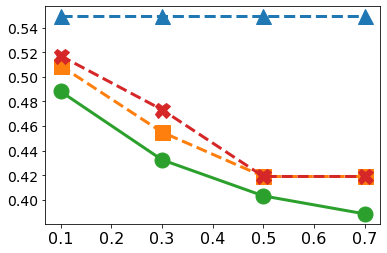

../../data/fig/eval/5-21-topk-test.pdf


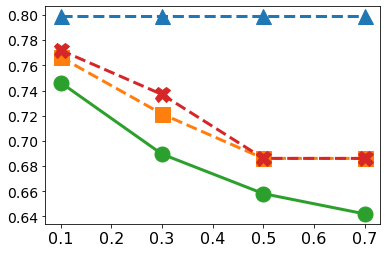

In [31]:
traintest = 'test'
labels = train_labels['5->21']
from_tos = {
    'inception_v3-512-0.5-0.9': ['inception_v3_512_0.5_0.9_11', 'inception_v3_512_0.5_0.9_121'],
    'vgg16-512-0.01-0.9': ['vgg16_512_0.01_0.9_5', 'vgg16_512_0.01_0.9_21']
}

path = {
        'top1': os.path.join(fig_dir, '5-21-top1-{}.pdf'.format(traintest)), 
        'topk': os.path.join(fig_dir, '5-21-topk-{}.pdf'.format(traintest))
}

draw_avg_graph(
    labels, input_dir, model, eval_type, eval_sample_ratios, from_tos, 
    path, traintest=traintest
)

../../data/fig/eval/21-207-top1-train.pdf


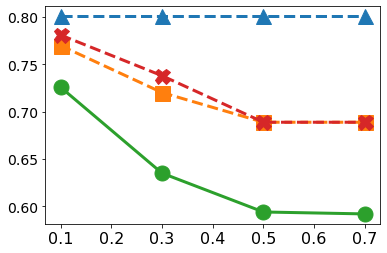

../../data/fig/eval/21-207-topk-train.pdf


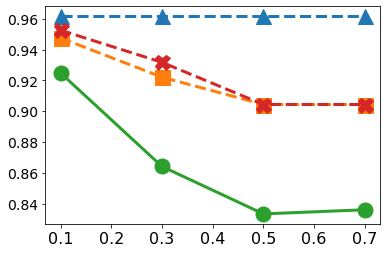

100

In [32]:
traintest = 'train'
labels = train_labels['21->207']
from_tos = {
    'inception_v3-512-0.5-0.9': ['inception_v3_512_0.5_0.9_11', 'inception_v3_512_0.5_0.9_121'],
    'vgg16-512-0.01-0.9': ['vgg16_512_0.01_0.9_21', 'vgg16_512_0.01_0.9_207']
}

path = {
        'top1': os.path.join(fig_dir, '21-207-top1-{}.pdf'.format(traintest)), 
        'topk': os.path.join(fig_dir, '21-207-topk-{}.pdf'.format(traintest))
}
eval_sample_ratios = [0.1, 0.3, 0.5, 0.7]
draw_avg_graph(
    labels, input_dir, model, eval_type, eval_sample_ratios, from_tos, 
    path, traintest=traintest
)
len(labels)

../../data/fig/eval/21-207-top1-test.pdf


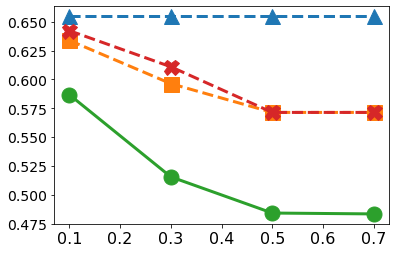

../../data/fig/eval/21-207-topk-test.pdf


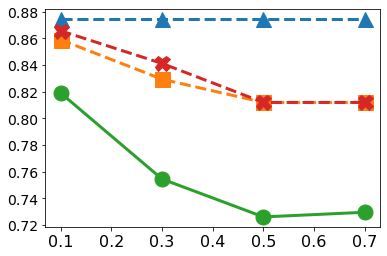

In [33]:
traintest = 'test'
# labels = train_labels['21->207']
# labels = [703, 707, 712, 830, 856, 903]
from_tos = {
    'inception_v3-512-0.5-0.9': ['inception_v3_512_0.5_0.9_11', 'inception_v3_512_0.5_0.9_121'],
    'vgg16-512-0.01-0.9': ['vgg16_512_0.01_0.9_21', 'vgg16_512_0.01_0.9_207']
}

path = {
        'top1': os.path.join(fig_dir, '21-207-top1-{}.pdf'.format(traintest)), 
        'topk': os.path.join(fig_dir, '21-207-topk-{}.pdf'.format(traintest))
}
draw_avg_graph(
    labels, input_dir, model, eval_type, eval_sample_ratios, from_tos, 
    path, traintest=traintest
)